In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

# Parameters for Kepler orbits
num_points_per_trajectory = 100
dt = 0.2  # Time step for integration

def kepler_orbit(t, state, GM=1.0):
    """
    Kepler orbit equations: d^2r/dt^2 = -GM * r / |r|^3
    state = [x, y, vx, vy]
    """
    x, y, vx, vy = state
    r = np.sqrt(x**2 + y**2)
    r3 = r**3
    ax = -GM * x / r3
    ay = -GM * y / r3
    return [vx, vy, ax, ay]

def generate_kepler_trajectory(eccentricity=0.5, semi_major_axis=1.0, angle=0.0, GM=1.0):
    """
    Generate a Kepler orbit trajectory.
    
    Args:
        eccentricity: Eccentricity of the ellipse (0 = circle, <1 = ellipse)
        semi_major_axis: Semi-major axis of the ellipse
        angle: Initial angle of the orbit
        GM: Gravitational parameter (mass of sun * gravitational constant)
    
    Returns:
        positions: array of shape (num_points, 2) with (x, y) positions
    """
    # Initial conditions for elliptical orbit
    # At perihelion (closest point to sun)
    r_peri = semi_major_axis * (1 - eccentricity)
    v_peri = np.sqrt(GM * (1 + eccentricity) / (semi_major_axis * (1 - eccentricity)))
    
    # Rotate by angle
    x0 = r_peri * np.cos(angle)
    y0 = r_peri * np.sin(angle)
    vx0 = -v_peri * np.sin(angle)
    vy0 = v_peri * np.cos(angle)
    
    initial_state = [x0, y0, vx0, vy0]
    
    # Integrate orbit
    t_span = (0, num_points_per_trajectory * dt)
    t_eval = np.linspace(0, num_points_per_trajectory * dt, num_points_per_trajectory)
    
    sol = solve_ivp(kepler_orbit, t_span, initial_state, t_eval=t_eval, 
                    args=(GM,), rtol=1e-8, atol=1e-8)
    
    positions = np.column_stack([sol.y[0], sol.y[1]])  # (num_points, 2)
    return positions

# Generate multiple trajectories with varying parameters
trajectories = []
for i in range(1010):
    e = np.random.uniform(0.1, 0.8)  # Eccentricity
    a = np.random.uniform(0.5, 2.0)  # Semi-major axis
    angle = np.random.uniform(0, 2 * np.pi)  # Initial angle
    traj = generate_kepler_trajectory(eccentricity=e, semi_major_axis=a, angle=angle)
    trajectories.append(traj)

trajectories = np.array(trajectories)


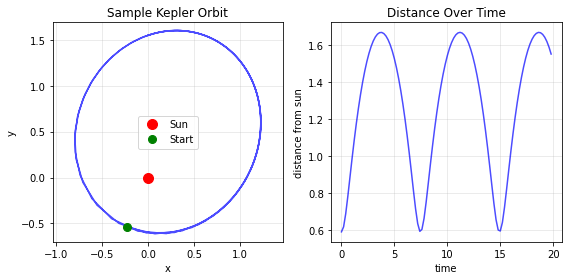

Trajectories shape: (1000, 100, 2)
Position range: x=[-3.384, 3.410], y=[-3.379, 3.408]


In [2]:
num_trajectories = 1000  # Shape: (num_trajectories, num_points, 2)
trajectories, trajectories_test = trajectories[:num_trajectories], trajectories[1000:]

# Plot a sample trajectory
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
traj_idx = 3
plt.plot(trajectories[traj_idx, :, 0], trajectories[traj_idx, :, 1], 'b-', alpha=0.7)
plt.plot(0, 0, 'ro', markersize=10, label='Sun')
plt.plot(trajectories[traj_idx, 0, 0], trajectories[traj_idx, 0, 1], 'go', markersize=8, label='Start')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sample Kepler Orbit')
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Plot distance from sun over time
distances = np.sqrt(trajectories[traj_idx, :, 0]**2 + trajectories[traj_idx, :, 1]**2)
times = np.arange(num_points_per_trajectory) * dt
plt.plot(times, distances, 'b-', alpha=0.7)
plt.xlabel('time')
plt.ylabel('distance from sun')
plt.title('Distance Over Time')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Trajectories shape: {trajectories.shape}")
print(f"Position range: x=[{trajectories[:,:,0].min():.3f}, {trajectories[:,:,0].max():.3f}], "
      f"y=[{trajectories[:,:,1].min():.3f}, {trajectories[:,:,1].max():.3f}]")


In [3]:
# Convert to PyTorch tensors - continuous 2D coordinates
# Input: trajectories[:,:-1] (all but last), Target: trajectories[:,1:] (all but first)
inputs = torch.from_numpy(trajectories[:,:-1]).float()  # shape: (num_trajectories, num_points-1, 2)
targets = torch.from_numpy(trajectories[:,1:]).float()   # shape: (num_trajectories, num_points-1, 2)

inputs_test = torch.from_numpy(trajectories_test[:,:-1]).float()  # shape: (num_trajectories, num_points-1, 2)
targets_test = torch.from_numpy(trajectories_test[:,1:]).float()   # shape: (num_trajectories, num_points-1, 2)

print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")
print(f"Input range: x=[{inputs[:,:,0].min():.3f}, {inputs[:,:,0].max():.3f}], "
      f"y=[{inputs[:,:,1].min():.3f}, {inputs[:,:,1].max():.3f}]")


Input shape: torch.Size([1000, 99, 2])
Target shape: torch.Size([1000, 99, 2])
Input range: x=[-3.384, 3.410], y=[-3.379, 3.408]


In [5]:
from model_cv import GPTConfigCV, GPTCV

seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

GPTConfigCV.block_size = num_points_per_trajectory
GPTConfigCV.input_dim = 2  # 2D coordinates (x, y)
GPTConfigCV.n_layer = 2
GPTConfigCV.n_head = 1
GPTConfigCV.n_embd = 32
GPTConfigCV.attention_alpha = 0.0
GPTConfigCV.bias = True

model = GPTCV(GPTConfigCV)



number of parameters: 0.025634M


Step 0, Loss: 0.066357


Step 100, Loss: 0.010198
Step 200, Loss: 0.008194
Step 300, Loss: 0.007121
Step 400, Loss: 0.006419
Step 500, Loss: 0.006055
Step 600, Loss: 0.005763
Step 700, Loss: 0.005333
Step 800, Loss: 0.005263
Step 900, Loss: 0.005056
Step 1000, Loss: 0.004711


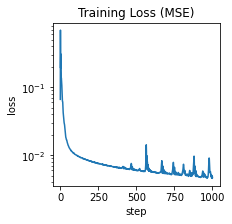

In [9]:
# Training
weight_decay = 0.0
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=weight_decay)

n_steps = 1001

losses = []

noise_scale = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
targets = targets.to(device)

for i in range(n_steps):
    inputs_noised = inputs + torch.randn_like(inputs) * noise_scale
    inputs_noised = inputs_noised.to(device)
    predictions, loss = model.forward(inputs_noised, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())
    if i % 100 == 0:
        print(f"Step {i}, Loss: {loss.item():.6f}")

plt.figure(figsize=(3, 3))
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Training Loss (MSE)')
plt.yscale('log')
plt.show()


Conditioning sequence shape: torch.Size([1, 50, 2])
Generating 50 more steps...

Error Statistics:
Mean position error: 0.180329
Max position error: 0.557933


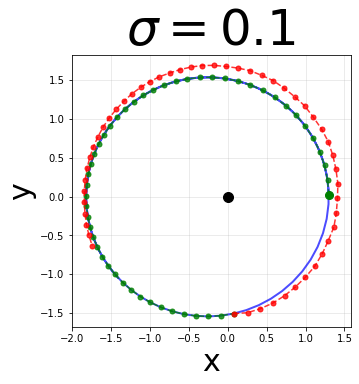

In [10]:
# Inference: Use first 50 steps as conditioning to generate later steps
model.eval()  # Set model to evaluation mode

# Select a sample trajectory for inference
traj_idx = 6
conditioning_length = 50

# Use first 50 steps as conditioning (shape: (1, 50, 2))
conditioning_seq = inputs_test[traj_idx:traj_idx+1, :conditioning_length]  # shape: (1, 50, 2)
conditioning_seq = conditioning_seq.to(device)

print(f"Conditioning sequence shape: {conditioning_seq.shape}")
print(f"Generating {num_points_per_trajectory - conditioning_length} more steps...")

# Generate remaining steps
num_steps_to_generate = num_points_per_trajectory - conditioning_length
with torch.no_grad():
    generated_seq = model.generate(conditioning_seq, max_new_tokens=num_steps_to_generate)

# Convert to numpy for plotting
conditioning_np = conditioning_seq.cpu().squeeze().numpy()  # (50, 2)
generated_np = generated_seq.cpu().squeeze().numpy()  # (100, 2)
true_trajectory_np = trajectories_test[traj_idx]  # Original full trajectory (100, 2)

# Create time arrays
times = np.arange(num_points_per_trajectory) * dt
t_conditioning = times[:conditioning_length]
t_generated = times  # Full time array for generated sequence
t_true = times  # Full time array for true trajectory

# Calculate errors
generated_full = generated_np  # (100, 2)
true_full = true_trajectory_np  # (100, 2)
position_error = np.sqrt(np.sum((generated_full - true_full)**2, axis=1))  # Distance error at each point
mean_error = np.mean(position_error)
max_error = np.max(position_error)

print(f"\nError Statistics:")
print(f"Mean position error: {mean_error:.6f}")
print(f"Max position error: {max_error:.6f}")

# Plot 1: 2D trajectory comparison
plt.figure(figsize=(5, 5))
plt.plot(true_full[:, 0], true_full[:, 1], 'b-', label='True trajectory', alpha=0.7, linewidth=2)
#plt.plot(conditioning_np[:, 0], conditioning_np[:, 1], 'g-', label='Conditioning (input)', alpha=0.8, linewidth=2)
# Plot first 50 points (conditioning) in green
plt.plot(generated_full[:50, 0], generated_full[:50, 1], 'g--', label='Generated (first 50)', alpha=0.8, linewidth=1.5, marker='o', markersize=5)
# Plot from point 49 onwards in red to ensure 50->51 transition is red dashed
plt.plot(generated_full[49:, 0], generated_full[49:, 1], 'r--', label='Generated (last 50)', alpha=0.8, linewidth=1.5, marker='o', markersize=5)
plt.plot(0, 0, 'ko', markersize=10, label='Sun')
plt.plot(conditioning_np[0, 0], conditioning_np[0, 1], 'go', markersize=8, label='Start')
plt.xlabel('x', fontsize=30)
plt.ylabel('y', fontsize=30)
plt.title(r'$\sigma = {}$'.format(noise_scale), fontsize=50)
#plt.legend(fontsize=25, loc="center")
plt.axis('equal')
plt.grid(True, alpha=0.3)

#plt.savefig(f'./plots/kepler_gen_traj_D_{100*num_trajectories}_noise_scale_{noise_scale}.png', dpi=300, bbox_inches='tight')